In [356]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torchvision import datasets
from torchvision import transforms
import numpy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cpu


In [357]:
# dataset = torchvision.datasets.MNIST(root="../data", train=True, download=True, transform=torchvision.transforms.ToTensor())

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    ])
dataset = datasets.ImageFolder(root="SkinData/data", transform=transform)
# data_loader = torch.utils.data.DataLoader(dataset)
# おっと、4が混ざりました。1か8か、あるいは4です。
# 好きな数字に変えても良いでしょう。
target_values = [0,1]

target_images = []
for data in dataset:
    if data[1] in target_values:
        target_images.append(data)

train_dataloader = DataLoader(target_images, batch_size=8, shuffle=True)

In [358]:
def corrupt(x, amount):
  """
    x : 入力する画像(複数), x.shape = torch.Size([batch_size, 1, 28, 28])
    amount : 各画像にどれだけノイズを入れるかの比率を入れたndarray, 0->そのまま, 1->完全にノイズ
  """
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) 
  return x*(1-amount) + noise*amount 


In [359]:
batch_size = 128
train_dataloader = DataLoader(target_images, batch_size=batch_size, shuffle=True)

max_epochs = 5

net = BasicUNet()
net.to(device)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) 

history = []
for epoch in range(max_epochs):
    for x, y in train_dataloader:
        x = x.to(device)
        # どれくらいノイズを入れるかは乱数で決める
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x)
        loss = loss_func(pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history.append(loss.item())

    avg_loss = sum(history[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

plt.plot(history)
plt.ylim(0, 0.1)


RuntimeError: The size of tensor a (26) must match the size of tensor b (30) at non-singleton dimension 3

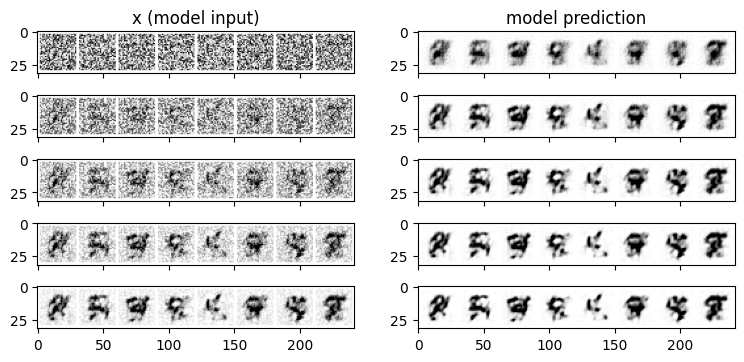

In [ ]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)
    pred_output_history.append(pred.detach().cpu())

    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor
    step_history.append(x.detach().cpu())

_, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')


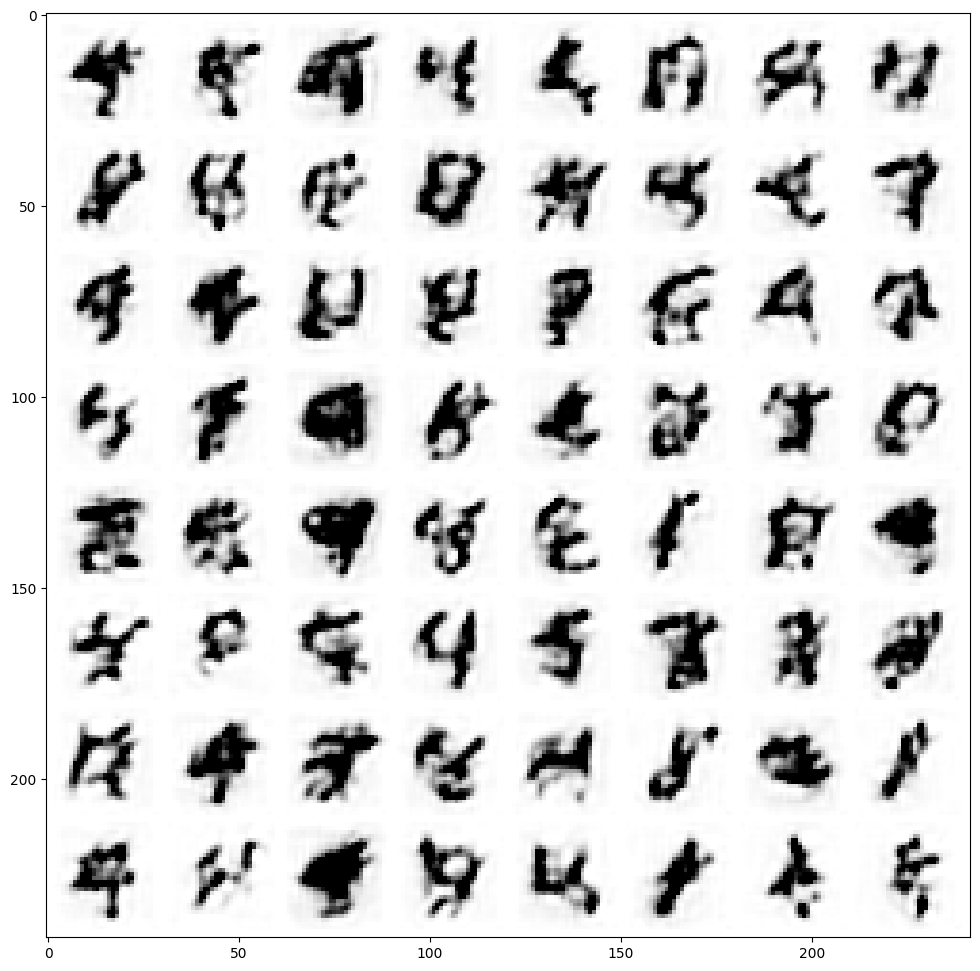

In [ ]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)

for i in range(n_steps):
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

Epoch 100/100, Alpha Loss: 0.9989258646965027

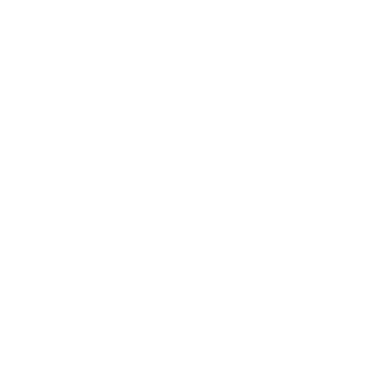

In [374]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="SkinData/3", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

input_dim = 64 * 64 * 3  # 64x64のRGB画像
model = DiffusionModel(input_dim=input_dim, hidden_dim=128, output_dim=input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 100
for epoch in range(num_epochs):
    for data in dataloader:
        images, _ = data
        images = images.view(images.size(0), -1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
    print(f"\rEpoch {epoch+1}/{num_epochs}, Loss: {loss.item()}",end="")

generated_images = model(torch.randn(1, input_dim))
generated_images = generated_images.view(3, 64, 64).detach().numpy()

plt.imshow(np.transpose(generated_images, (1, 2, 0)))
plt.axis('off')
plt.show()
